/Users/sophi/pytorch-test/env/lib/python3.8/site-packages/lightning/fabric/__init__.py:41: Deprecated call to `pkg_resources.declare_namespace('lightning.fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
/Users/sophi/pytorch-test/env/lib/python3.8/site-packages/pkg_resources/__init__.py:2350: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)
/Users/sophi/pytorch-test/env/lib/python3.8/site-packages/lightning/pytorch/__init__.py:37: Deprecated call to `pkg_resources.declare_namespace('lightning.pytorch')`.
Implementing implicit namespace packages 

tensor([-1000., -1000.,    -1.])


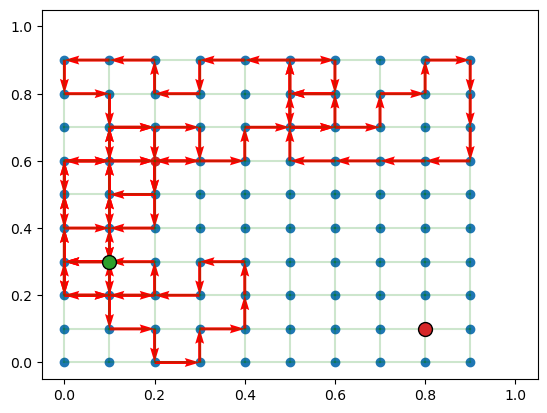

In [1]:
from SPPenv import SPPEnv
from utils import rollout, random_policy

batch_size = 3

env = SPPEnv(num_loc=100)
reward, td, actions = rollout(env, env.reset(batch_size=batch_size), random_policy)
print(reward)
env.render(td, actions)

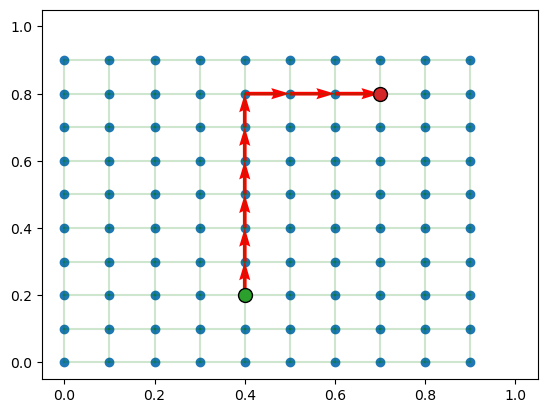

In [2]:
from astar import AStarSearch
from SPPenv import SPPEnv

env = SPPEnv(num_loc=100)
astar = AStarSearch(env)
came_from, _ = astar.search()
astar.render(came_from)

In [3]:
from SPPembeddings import SPPInitEmbedding, SPPContext, StaticEmbedding
from rl4co.models.zoo import AttentionModel, AutoregressivePolicy, POMO, POMOPolicy

env = SPPEnv(num_loc=100)

# policy = AttentionModelPolicy(env.name, 
#                               embedding_dim=128, 
#                               num_encoder_layers=3,
#                               num_heads=8,)

# policy = AutoregressivePolicy(
#     env=env,
#     model=policy,
#     max_steps=100,
#     rollout_fn=rollout,
#     rollout_kwargs={"policy": greedy},
# )

# Instantiate policy with the embeddings we created above
emb_dim = 64
policy = AutoregressivePolicy(env,
                              embedding_dim=emb_dim,
                              init_embedding=SPPInitEmbedding(emb_dim),
                              context_embedding=SPPContext(emb_dim),
                              dynamic_embedding=StaticEmbedding(emb_dim)
)



# policy = POMOPolicy(env,
#                         embedding_dim=emb_dim,
#                         init_embedding=SPPInitEmbedding(emb_dim),
#                         context_embedding=SPPContext(emb_dim),
#                         dynamic_embedding=StaticEmbedding(emb_dim))

# model = POMO(env, policy=policy,
#                   baseline='shared',
#                   batch_size=3,
#                   train_data_size=100_0,
#                   val_data_size=100,)

# Model: default is AM with REINFORCE and greedy rollout baseline
model = AttentionModel(env,
                       policy=policy,
                       baseline='rollout',
                       train_data_size=100_0,
                       val_data_size=100,)

/Users/sophi/pytorch-test/env/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/Users/sophi/pytorch-test/env/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


Problem 1 | Cost: 2.000
Problem 2 | Cost: 1000.000
Problem 3 | Cost: 5.000


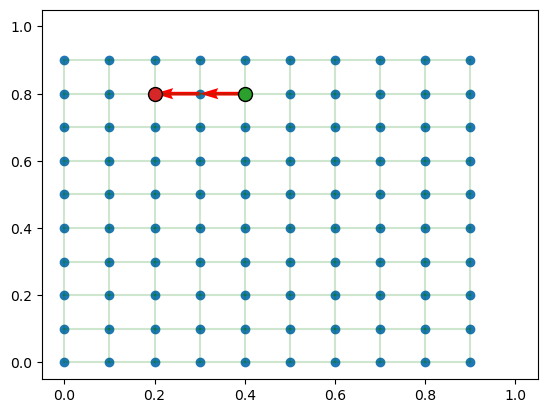

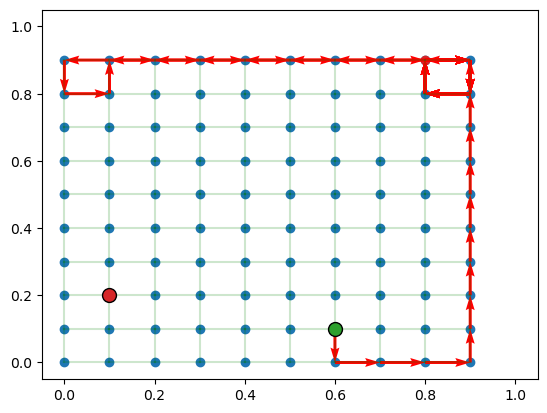

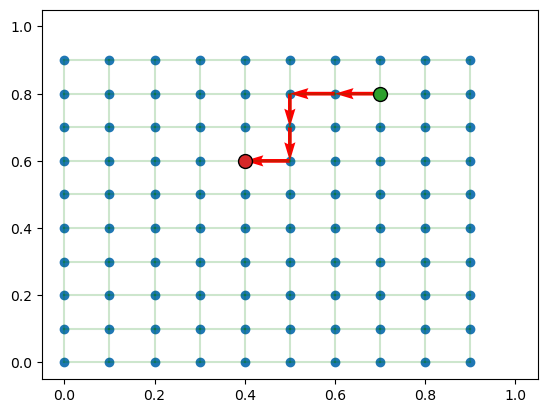

In [4]:
import torch
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out["actions"].cpu().detach()
rewards_untrained = out["reward"].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

In [ ]:
from rl4co.utils.trainer import RL4COTrainer

trainer = RL4COTrainer(
    max_epochs=3,
    accelerator="mps",
    devices=1,
    logger=None
)

trainer.fit(model)

Using 16bit Automatic Mixed Precision (AMP)
/Users/sophi/pytorch-test/env/lib/python3.8/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sophi/pytorch-test/env/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
val_file not set. Generating dataset instead
test_file not set. Gene

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/sophi/pytorch-test/env/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/sophi/pytorch-test/env/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/sophi/pytorch-test/env/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/sophi/pytorch-test/env/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval

Training: |                                               | 0/? [00:00<?, ?it/s]

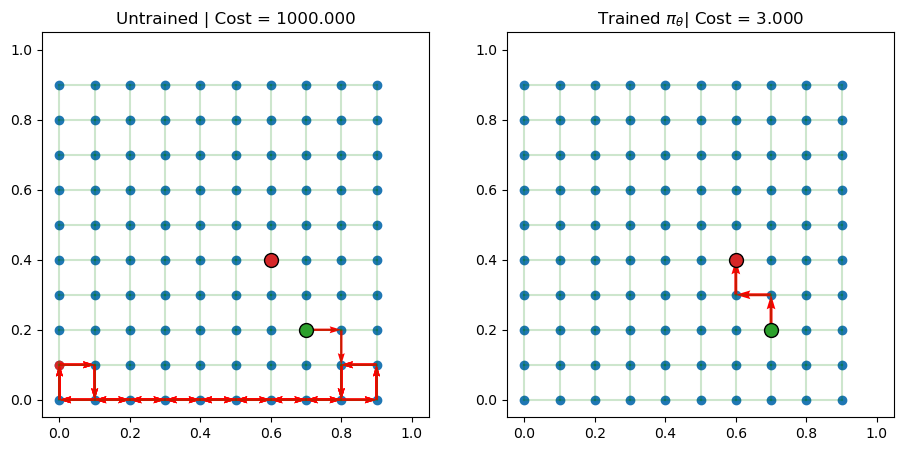

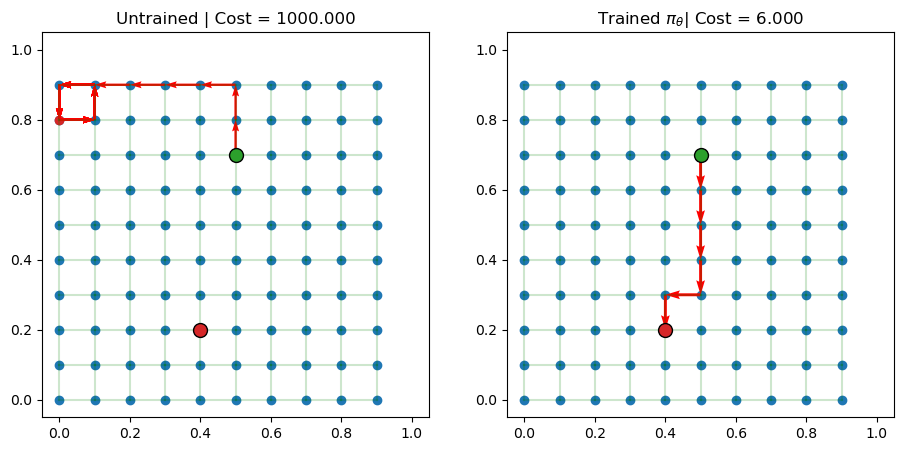

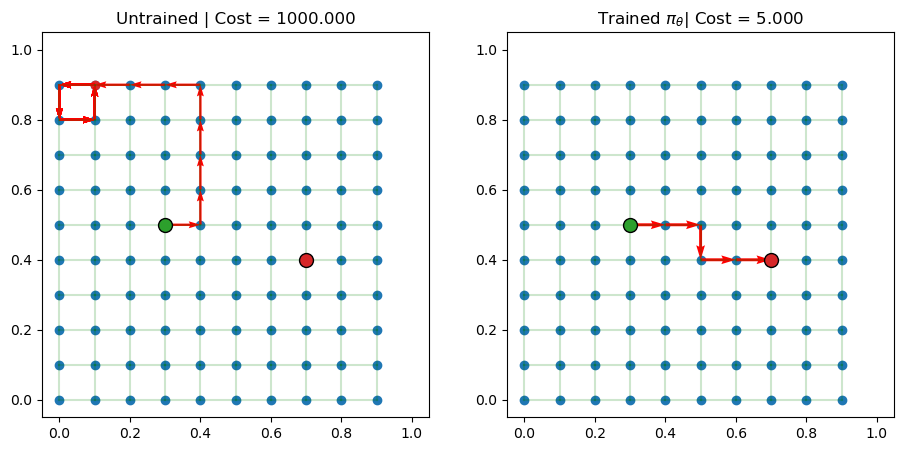

In [6]:
infer_env = SPPEnv(num_loc=1000)

model = model.to(device)
out = model(td_init.clone(),env=infer_env, phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    env.render(td, actions_untrained[i], ax=axs[0])
    infer_env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")